# Описание проекта

Подготовьте прототип модели машинного обучения. Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

### Технологический процесс  
  
Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.

![gold](https://i.ibb.co/SQGQjR4/viruchka-1576238830.jpg)  
  
##### 1. Флотация  
  
Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).  
  
##### 2. Очистка  
  
Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

### Описание данных  
  
#### Технологический процесс  
  
  - Rougher feed — исходное сырье
  - Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant  
    - Xanthate **— ксантогенат (промотер, или активатор флотации);
    - Sulphate — сульфат (на данном производстве сульфид натрия);
    - Depressant — депрессант (силикат натрия).  
  - Rougher process (англ. «грубый процесс») — флотация  
  - Rougher tails — отвальные хвосты  
  - Float banks — флотационная установка
  - Cleaner process — очистка
  - Rougher Au — черновой концентрат золота
  - Final Au — финальный концентрат золота
  
#### Параметры этапов  
  
  - air amount — объём воздуха  
  - fluid levels — уровень жидкости
  - feed size — размер гранул сырья
  - feed rate — скорость подачи

### Наименование признаков  
  
Наименование признаков должно быть такое:  
[этап].[тип_параметра].[название_параметра]  
Пример: `rougher.input.feed_ag`  
  
Возможные значения для блока [этап]:  
  
  - rougher — флотация  
  - primary_cleaner — первичная очистка  
  - secondary_cleaner — вторичная очистка
  - final — финальные характеристики  
  
Возможные значения для блока [тип_параметра]:  
  
  - input — параметры сырья  
  - output — параметры продукта
  - state — параметры, характеризующие текущее состояние этапа
  - calculation — расчётные характеристики

### План работы  
  
##### Шаг 1. Подготовим данные   
  - Откроем и изучим их  
  - Проверим, что эффективность обогащения на обучающей выборке рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery. Найдём MAE между нашими расчётами и значением признака. Сформулируем выводы.  
  - Проанализируем признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?
  - Проведём предобработку данных.
  
##### Шаг 2. Проанализируем данные
  - Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Сформулируем выводы
  - Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.
  - Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Сформулируем выводы и удалим аномалии.   
  
##### Шаг 3. Построим модель
  - Напишем функцию для вычисления итоговой sMAPE  
  - Обучим модели и оценим их качество. Выберем лучшую модель и проверим её на тестовой выборке. Сформулируем выводы.

# 1. Подготовка данных

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import RandomState
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test.csv')
df_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
print('Размер датасета train:', df_train.shape)
print('Размер датасета test:', df_test.shape)
print('Размер датасета full:', df_full.shape)

Размер датасета train: (16860, 87)
Размер датасета test: (5856, 53)
Размер датасета full: (22716, 87)


#### Изучим датасеты

Данные индексируются датой и временем получения информации (признак date).  
Соседние по времени параметры часто похожи.  
  
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.  
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

In [4]:
df_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [5]:
df_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

In [6]:
df_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

В тестовой выборке 53 признака, на 34 меньше чем в обучающей (87).

In [9]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

У тестовых данных отсутствуют целевые столбцы. А df_full это исходный датасет, который содержит (по условию задачи) все признаки из обеих выборок. Из него можем извлечь данные для теста. 

In [10]:
# дадим тренировочным данным лейбл чтобы потом их легко найти в полной (full) выборке
df_train['train'] = 1
# объединим
df = df_full.merge(df_train[['train','date']],how='left',on='date')
# остальные заполним нулям, выделим таким образом тестовую выборку
df['train'].fillna(0,inplace=True)
df['train'].value_counts()

1.0    16860
0.0     5856
Name: train, dtype: int64

Таким образом мы сохранили размеры обеих выборок и получили все признаки.

Присутствуют множественные пропуске, посмотрим где и сколько, а позже решим, что с ними делать.

In [11]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [12]:
missing_data(df)

,Total,Percent
rougher.output.recovery,3119,13.730410
rougher.output.tail_ag,2737,12.048776
rougher.output.tail_au,2736,12.044374
rougher.output.tail_sol,2736,12.044374
rougher.input.floatbank11_xanthate,2257,9.935728
secondary_cleaner.output.tail_sol,2215,9.750836
final.output.recovery,1963,8.641486
rougher.calculation.au_pb_ratio,1627,7.162353
primary_cleaner.input.sulfate,1609,7.083113
primary_cleaner.input.depressant,1546,6.805776


Больше всего пропусков в rougher.output.recovery (13.73%) это эффективность обогащения на этапе флотации.

#### Для облегчения навигации по признакам, выведем их в виде таблицы:

![table](https://i.ibb.co/3cqmrGg/Screenshot-at-2021-01-17-15-33-10.png)  

![table](https://i.ibb.co/SPhhXzf/Screenshot-at-2021-01-17-15-56-43.png)

![table](https://i.ibb.co/BLKb19T/Screenshot-at-2021-01-17-16-00-31.png)

![table](https://i.ibb.co/kXpbXZC/Screenshot-at-2021-01-17-16-00-47.png)

![table](https://i.ibb.co/TqyDRfb/Screenshot-at-2021-01-17-16-01-03.png)

### Проверим, что эффективность обогащения на обучающей выборке рассчитана правильно.

#### Формула для для расчета эффективности обогащения:

![recovery](https://i.ibb.co/615jpGz/Recovery-1576238822.jpg)  

где:  
  - C — доля золота в концентрате после флотации/очистки;
  - F — доля золота в сырье/концентрате до флотации/очистки;
  - T — доля золота в отвальных хвостах после флотации/очистки.

В таблицах выше отмечены признаки которые пригодятся для расчета по формуле.

In [13]:
df['rougher.output.recovery'].head()

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
Name: rougher.output.recovery, dtype: float64

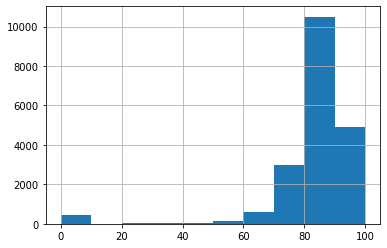

In [14]:
df['rougher.output.recovery'].hist();

Нет значений больше 100, но нулевые.

In [15]:
df[df['rougher.output.recovery'] <= 0]['rougher.output.recovery'].count()

419

Данных эффективности обогащения на этапе флотации равных нулю не так уж много, можно удалить.

In [16]:
df = df[df['rougher.output.recovery'] > 0]

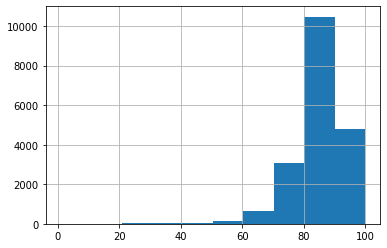

In [17]:
df['rougher.output.recovery'].hist();

In [18]:
df['rougher.output.recovery'].count()

19178

In [19]:
missing_data(df)

,Total,Percent
secondary_cleaner.output.tail_sol,1787,9.317969
rougher.input.floatbank11_xanthate,435,2.268224
primary_cleaner.output.concentrate_sol,419,2.184795
rougher.state.floatbank10_e_air,376,1.960580
final.output.concentrate_sol,229,1.194077
secondary_cleaner.state.floatbank2_a_air,219,1.141933
primary_cleaner.output.concentrate_pb,155,0.808218
rougher.input.feed_size,149,0.776932
final.output.recovery,133,0.693503
rougher.input.feed_pb,123,0.641360


Данные стали чище. Остальные отпавшие данные нам не так интересны, так как они без целевого признака.

In [20]:
def get_recovery(row):
    try:
        c = row['rougher.output.concentrate_au']
        f = row['rougher.input.feed_au']
        t = row['rougher.output.tail_au']
        row['rougher.output.recovery_calc'] = ((c * (f - t)) / (f * (c - t))) * 100
    except ZeroDivisionError:
        return row
    return row

In [21]:
df = df.apply(get_recovery,axis=1)

In [22]:
df['rougher.output.recovery'].head()

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
Name: rougher.output.recovery, dtype: float64

In [23]:
df['rougher.output.recovery_calc'].head()

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
Name: rougher.output.recovery_calc, dtype: float64

In [24]:
df['rougher.output.recovery_calc'].describe()

count    19178.000000
mean        84.893209
std          8.097597
min          0.988506
25%         81.358877
50%         86.323607
75%         90.079906
max        100.000000
Name: rougher.output.recovery_calc, dtype: float64

Нет значений больше 100, расчеты выглядят корректно.

### Найдём MAE между нашими расчётами и значением признака.

In [25]:
mae = mean_absolute_error(df['rougher.output.recovery'], df['rougher.output.recovery_calc'])
'{0:.20f}'.format(mae)

'0.00000000000001003066'

#### Вывод  
  
Ошибка стремится к нулю. Значит расчеты в предоставленном датасете и наши совпадают. Удалим ненужную колонку.

In [26]:
df = df.drop('rougher.output.recovery_calc', axis=1)

### Проанализируем признаки, недоступные в тестовой выборке.

In [27]:
cols = [col for col in df.columns if col not in df_test.columns]
print(len(cols))
cols

35


['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

В основном отсутствующие признаки это "отвальные хвосты" (tail) и концентраты (concentrate)
на всех этапах. В тестовой выборке недоступны некоторые расчетные (calculation) и выходные (output)
 характеристики процесса, т.к. их невозможно получить/измерить во время выполнения
 технологического процесса. Это так же оба целевых признака которые необходимо будет найти rougher.output.recovery', final.output.recovery.
И технические показатели описания которых не было в задании:
  
('rougher.calculation.sulfate_to_au_concentrate',  
 'rougher.calculation.floatbank10_sulfate_to_au_feed',  
 'rougher.calculation.floatbank11_sulfate_to_au_feed',  
 'rougher.calculation.au_pb_ratio')  

### Проведём предобработку данных.

#### Изменим тип данных на дату.

In [28]:
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d %H:%M:%S')

#### Очистим данные от пропусков.

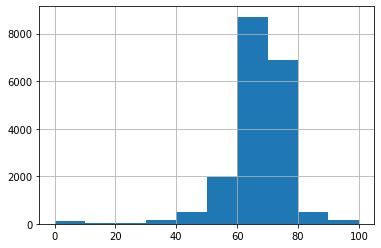

In [29]:
df['final.output.recovery'].hist();

Нет значений больше 100, но нулевые.

In [30]:
df = df[df['final.output.recovery'] > 0]

In [31]:
df.dropna(inplace = True)

In [32]:
missing_data(df)

,Total,Percent
train,0,0.0
secondary_cleaner.state.floatbank6_a_level,0,0.0
primary_cleaner.state.floatbank8_a_level,0,0.0
primary_cleaner.state.floatbank8_b_air,0,0.0
primary_cleaner.state.floatbank8_b_level,0,0.0
primary_cleaner.state.floatbank8_c_air,0,0.0
primary_cleaner.state.floatbank8_c_level,0,0.0
primary_cleaner.state.floatbank8_d_air,0,0.0
primary_cleaner.state.floatbank8_d_level,0,0.0
rougher.calculation.sulfate_to_au_concentrate,0,0.0


In [33]:
df['train'].value_counts()

1.0    10784
0.0     4969
Name: train, dtype: int64

Осталось довольно много данных. А тестовая выборка почти не уменьшилась (16860, 5856).

### Разделим выборки

Будем обучать одну модель, которая будет предсказывать два целевых признака для этапа "Флотации", там целевой признак будет rougher.output.recovery и на финальном этапе final.output.recovery.  
  
Уменьшим количество необходимых признаков тренировочной выборки до такого же как на тестовой. В тестовую добавим целевых признаков (чтобы их можно было выделить для проверки).

In [34]:
final_columns = [col for col in df.columns if col in df_test.columns]
final_columns.append("rougher.output.recovery")
final_columns.append("final.output.recovery")
final_columns

['date',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air'

In [35]:
target_column_rougher = "rougher.output.recovery"
target_column_final = "final.output.recovery"

train_df = df[df['train']==1]
test_df = df[df['train']==0]

train_df = train_df.drop('train', axis=1)
test_df = test_df.drop('train', axis=1)

# оставили только необходимы столбцы
train_df = train_df[final_columns]
test_df = test_df[final_columns]

# Тренировочная
train = train_df.copy()
target_rougher = train[target_column_rougher]
target_final = train[target_column_final]
features = train.drop([target_column_rougher, target_column_final], axis=1)

features_train_rougher, features_valid_rougher, target_train_rougher, target_valid_rougher = train_test_split(
    features, target_rougher, test_size=0.25, random_state=12345)

features_train_final, features_valid_final, target_train_final, target_valid_final = train_test_split(
    features, target_final, test_size=0.25, random_state=12345)

# Тестовая
test_data = test_df.copy()
target_test_rougher = test_data[target_column_rougher]
target_test_final = test_data[target_column_final]
features_test = test_data.drop([target_column_rougher, target_column_final], axis=1)

In [36]:
features_train_rougher.shape, target_train_rougher.shape, features_valid_rougher.shape, target_valid_rougher.shape

((8088, 53), (8088,), (2696, 53), (2696,))

In [37]:
features_train_final.shape, target_train_final.shape, features_valid_final.shape, target_valid_final.shape

((8088, 53), (8088,), (2696, 53), (2696,))

In [38]:
target_test_rougher.shape, target_test_final.shape, features_test.shape

((4969,), (4969,), (4969, 53))

# 2. Проанализируем данные

### Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

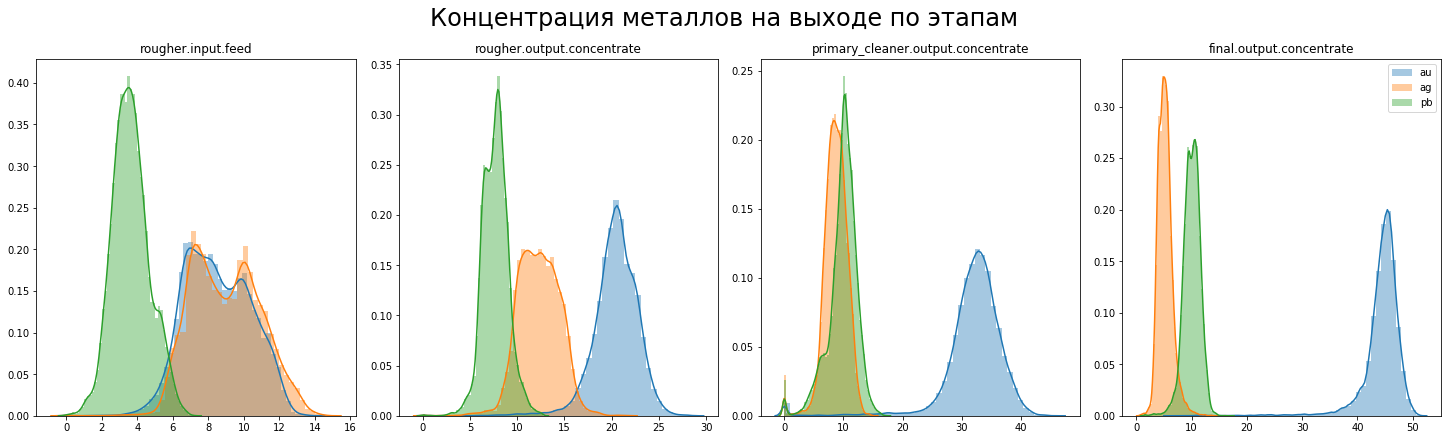

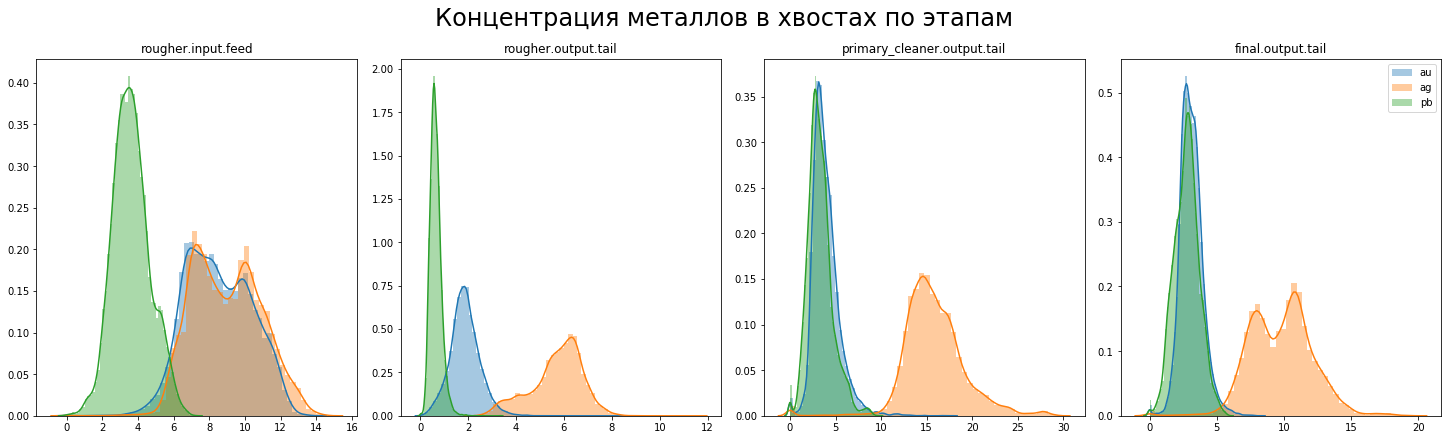

In [39]:
process = ['rougher.input.feed',
           'rougher.output.concentrate',
           'primary_cleaner.output.concentrate',
           'final.output.concentrate']

process_tail = ['rougher.input.feed',
                'rougher.output.tail',
                'primary_cleaner.output.tail',
                'final.output.tail']

metals = ['au', 'ag', 'pb']

fig, axs = plt.subplots(1, len(process), figsize=(20, 6), constrained_layout=True)
fig.suptitle('Концентрация металлов на выходе по этапам', fontsize=24)

for stage, ax in zip(process, axs):
    ax.set_title(stage)
    for metal in metals:        
        cols = df.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(df.loc[:, cols].dropna(), label=metal, ax=ax)    
plt.legend()

fig, axs = plt.subplots(1, 4, figsize=(20, 6), constrained_layout=True)
fig.suptitle('Концентрация металлов в хвостах по этапам', fontsize=24)

for stage, ax in zip(process_tail, axs):
    ax.set_title(stage)
    for metal in metals:        
        cols = df.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(df.loc[:, cols].dropna(), label=metal, ax=ax)   
plt.legend()

plt.show()

На каждом этапе концентрация золота растет, а в хвостах количество золота падает.

### Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.

Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

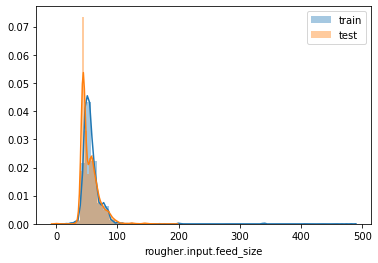

In [40]:
sns.distplot(df[df['train']==1]['rougher.input.feed_size'].dropna(), label='train');
sns.distplot(df[df['train']==0]['rougher.input.feed_size'].dropna(), label='test');
plt.legend();

Распределения размеров гранул сырья в двух выборках (обучающей и тестовой) близки, можно оставить так как есть.

### Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

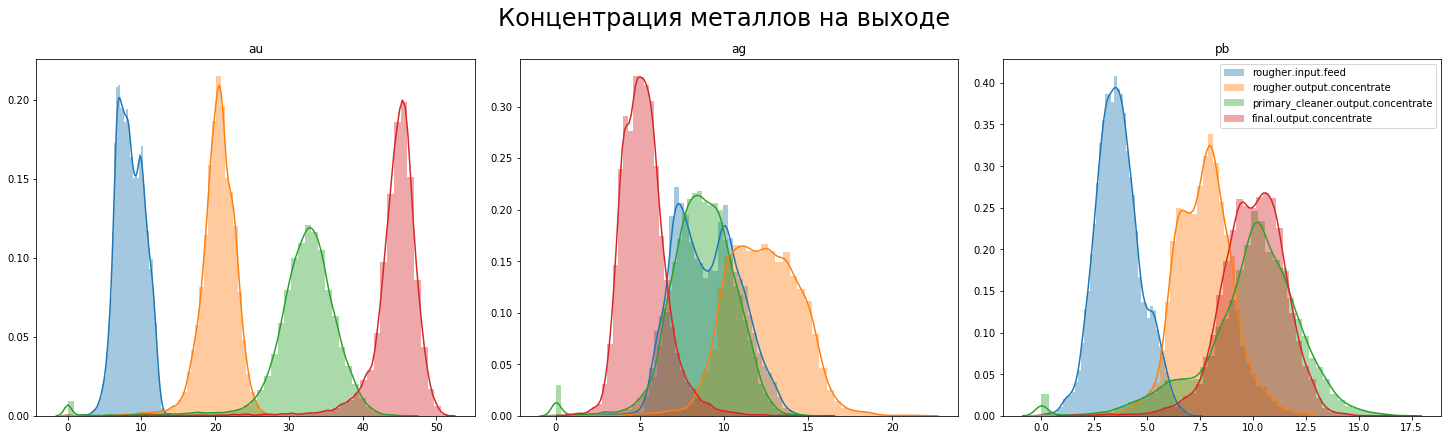

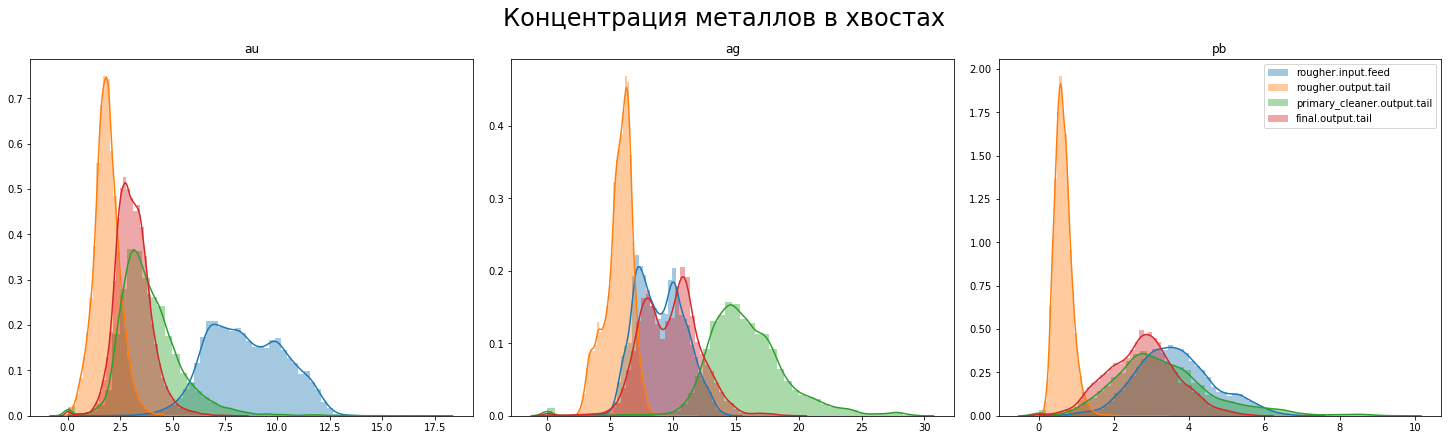

In [41]:
fig, axs = plt.subplots(1, len(metals), figsize=(20, 6), constrained_layout=True)
fig.suptitle('Концентрация металлов на выходе', fontsize=24)

for metal, ax in zip(metals, axs):
    ax.set_title(metal)
    for stage in process:
        cols = df.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(df.loc[:, cols].dropna(), label=stage, ax=ax)   
plt.legend()

fig, axs = plt.subplots(1, len(metals), figsize=(20, 6), constrained_layout=True)
fig.suptitle('Концентрация металлов в хвостах', fontsize=24)

for metal, ax in zip(metals, axs):
    ax.set_title(metal)
    for stage in process_tail:
        cols = df.columns.str.contains(stage+'_'+metal)
        sns_ax = sns.distplot(df.loc[:, cols].dropna(), label=stage, ax=ax)   
plt.legend()

plt.show()

Четко различается увеличение концентрации золота на каждом этапе. У остальных металлов нет
такого четкого разделения.
Концентрация золота больше в хвостах после флотации, как и у остальных металлов.

# 3. Построим модель

### Напишем функцию для вычисления итоговой sMAPE  
  
![sMAPE](https://i.ibb.co/TWBdLrF/smape-1576239058.jpg)  
![_sMAPE](https://i.ibb.co/VjQ4fRG/smape-1576239054.jpg)

In [42]:
def get_final_smape(smape_rougher, smape_final):
    return 0.25*smape_rougher + 0.75*smape_final

### Обучим модели и оценим их качество.

Загрузим catboost, у него кросс-валидация происходит автоматически внутри алгоритма.

In [43]:
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable


In [44]:
from catboost import CatBoostRegressor

In [45]:
model_rougher = CatBoostRegressor(verbose=100)
model_final = CatBoostRegressor(verbose=100)

In [46]:
model_rougher.fit(features_train_rougher, target_train_rougher, eval_set=(features_valid_rougher, target_valid_rougher))

0:	learn: 7.3532569	test: 7.3682995	best: 7.3682995 (0)	total: 84ms	remaining: 1m 23s
100:	learn: 3.9784116	test: 4.4432491	best: 4.4432491 (100)	total: 7.2s	remaining: 1m 4s
200:	learn: 3.4486937	test: 4.1199529	best: 4.1199529 (200)	total: 12.9s	remaining: 51.4s
300:	learn: 3.1548308	test: 3.9590032	best: 3.9590032 (300)	total: 18.7s	remaining: 43.4s
400:	learn: 2.9123580	test: 3.8554489	best: 3.8554489 (400)	total: 24.5s	remaining: 36.6s
500:	learn: 2.7244353	test: 3.7693160	best: 3.7693160 (500)	total: 30.5s	remaining: 30.4s
600:	learn: 2.5780100	test: 3.7143714	best: 3.7141204 (597)	total: 36.3s	remaining: 24.1s
700:	learn: 2.4440265	test: 3.6649686	best: 3.6649686 (700)	total: 41.9s	remaining: 17.9s
800:	learn: 2.3366775	test: 3.6324055	best: 3.6324055 (800)	total: 47.8s	remaining: 11.9s
900:	learn: 2.2400062	test: 3.6018508	best: 3.6018508 (900)	total: 53.6s	remaining: 5.89s
999:	learn: 2.1491272	test: 3.5750768	best: 3.5749836 (998)	total: 59.4s	remaining: 0us

bestTest = 3.574

Качество RMSE лучшей модели у меня получилось 3.574983649

In [47]:
model_final.fit(features_train_final, target_train_final, eval_set=(features_valid_final, target_valid_final))

0:	learn: 8.0914816	test: 7.9456615	best: 7.9456615 (0)	total: 12.4ms	remaining: 12.4s
100:	learn: 5.7634398	test: 5.7961044	best: 5.7961044 (100)	total: 6.33s	remaining: 56.3s
200:	learn: 5.3123099	test: 5.5302168	best: 5.5302168 (200)	total: 12.3s	remaining: 48.7s
300:	learn: 5.0007105	test: 5.3868284	best: 5.3868284 (300)	total: 18.1s	remaining: 42s
400:	learn: 4.7244096	test: 5.2717867	best: 5.2712882 (399)	total: 24s	remaining: 35.9s
500:	learn: 4.4897302	test: 5.1769427	best: 5.1769427 (500)	total: 30s	remaining: 29.9s
600:	learn: 4.2932284	test: 5.1142469	best: 5.1138565 (598)	total: 36s	remaining: 23.9s
700:	learn: 4.1175792	test: 5.0695468	best: 5.0695468 (700)	total: 41.7s	remaining: 17.8s
800:	learn: 3.9549692	test: 5.0198333	best: 5.0198333 (800)	total: 47.1s	remaining: 11.7s
900:	learn: 3.8044346	test: 4.9747169	best: 4.9747169 (900)	total: 52.8s	remaining: 5.8s
999:	learn: 3.6714887	test: 4.9393971	best: 4.9393971 (999)	total: 58.5s	remaining: 0us

bestTest = 4.939397096


Качество RMSE лучшей модели у меня получилось 4.939397096

In [48]:
predicts_rougher = model_rougher.predict(features_test)
predicts_rougher

array([89.46594893, 89.11180841, 88.29211051, ..., 92.93455083,
       93.14445376, 92.70251504])

In [49]:
predicts_final = model_final.predict(features_test)
predicts_final

array([67.92425458, 67.55245006, 66.03449121, ..., 70.42799952,
       72.51836458, 71.66410075])

In [50]:
def get_metrics(target_valid, predicted_valid, target_train):
    metrics = {}
    metrics['mse'] =  round(mean_squared_error(target_valid, predicted_valid),4)
    metrics['rmse'] =  round(metrics['mse'] ** 0.5,4)
    metrics['r2'] =  round(r2_score(target_valid, predicted_valid),4)
    metrics['mae'] =  round(mean_absolute_error(target_valid, predicted_valid),4)
    predicted_valid_for_median = pd.Series(target_train.median(), index=target_valid.index)
    metrics['mae_median'] =  round(mean_absolute_error(target_valid, predicted_valid_for_median),4)
    metrics['sMAPE'] =  round(1/len(target_valid) * np.sum(2 * np.abs(predicted_valid-target_valid) / (np.abs(target_valid) + np.abs(predicted_valid))*100),4)
    return metrics

In [51]:
metrics_rougher = get_metrics(target_test_rougher, predicts_rougher, target_train_rougher)
metrics_rougher

{'mse': 14.8128,
 'rmse': 3.8487,
 'r2': 0.4513,
 'mae': 2.7826,
 'mae_median': 4.076,
 'sMAPE': 3.2989}

У меня получилось для rougher  
'mse': 14.8128,  
'rmse': 3.8487,  
'r2': 0.4513,  
'mae': 2.7826,  
'mae_median': 4.076,  
'sMAPE': 3.2989

Оценка mae 2.7826 обученной модели лучше чем медианная mae_median 4.076. 'sMAPE': 3.2989

In [52]:
metrics_final = get_metrics(target_test_final, predicts_final, target_train_final)
metrics_final

{'mse': 49.0087,
 'rmse': 7.0006,
 'r2': -0.0435,
 'mae': 5.2007,
 'mae_median': 5.3515,
 'sMAPE': 7.7357}

У меня получилось для final  
'mse': 49.0087,  
'rmse': 7.0006,  
'r2': -0.0435,  
'mae': 5.2007,  
'mae_median': 5.3515,  
'sMAPE': 7.7357

In [53]:
final_smape = get_final_smape(metrics_rougher['sMAPE'], metrics_final['sMAPE'])
round(final_smape,4)

6.6265

Итоговая sMAPE 6.6265

## Выводы

Заказчиком был дан большой датасет. С пропусками и отсутствующими признаками. В начале работы датасеты были приведены в надлежащий вид и очищены от пропусков. Проверина на корректность предоставленая в датасете метрика Recovery после этапа Флотации. Она оказалась посчитана корректно.  Что показала MAE между нашим расчетным и в датасете.
  
По заданию нужно обучить две модели предсказывать две целевые метрики rougher.output.recovery после этапа Флотации. И  final.output.recovery после финального этапа. Данные были разделены на тестовую и валидационные выборки. Все признаки используемые для обучения моделей были взяты такие же как в тестовой выборке, чтобы избавиться от эффекта "заглядывания в будущее" когда модель учится на данных которых она не должна знать.  
  
Судя по анализу данных, на каждом этапе концентрация золота растет, а в хвостах количество золота падает. Распределения размеров гранул сырья в двух выборках (обучающей и тестовой) близки. Четко различается увеличение концентрации золота на каждом этапе. У остальных металлов нет такого четкого разделения.
Концентрация золота больше в хвостах после флотации, как и у остальных металлов.  
  
Были построены две модели на основании CatBoostRegressor. Модель для этапа rougher показала'sMAPE': 3.2989. А модель для финального этапа показала 'sMAPE' 7.7357, чем этот параметр меньше тем меньше ошибка.  
  
Итоговое sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение») 6.6265, похоже на правду и приближено к реальному диапазону 7-10%.